## Import libraries

In [1]:
import gc
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow_addons.optimizers import AdamW, Lookahead
from tensorflow.keras.layers import Dense, Dropout, Add
from tensorflow.keras.layers import Activation, Input
from tensorflow.keras.layers import BatchNormalization

## Prepare data for model training

In [2]:
with open("../input/customer-churn-rate-preprocess-data/Churn_Risk_Rate_Dataset.txt", 'rb') as handle: 
    data = handle.read()

processed_data = pickle.loads(data)
train_df = processed_data['train_df']
test_df = processed_data['test_df']

del processed_data
gc.collect()

22

In [3]:
train_df['churn_risk_score'] = train_df['churn_risk_score'].apply(lambda x: 0 if x==5 else 1 if x==-1 else x)
train_df.groupby(['churn_risk_score']).size().reset_index().rename(columns={0:'count'})

,churn_risk_score,count
0,0,9825
1,1,3815
2,2,2741
3,3,10422
4,4,10184


In [4]:
cat_cols = ['region_category','membership_category','preferred_offer_types','internet_option',
            'complaint_status','feedback','age_category','joining_dt_year','time_category',
            'complaint_category','feedback_category','last_login_category']

for col in cat_cols:
    dummy_val = pd.get_dummies(train_df[col], prefix='col')
    train_df = pd.concat([train_df, dummy_val], axis=1)
    train_df.drop([col], inplace=True, axis=1)

print("train_df: {}".format(train_df.shape))

for col in cat_cols:
    dummy_val = pd.get_dummies(test_df[col], prefix='col')
    test_df = pd.concat([test_df, dummy_val], axis=1)
    test_df.drop([col], inplace=True, axis=1)

print("test_df: {}".format(test_df.shape))

train_df: (36987, 143)
test_df: (19919, 142)


In [5]:
Xtrain = train_df.loc[:, train_df.columns != 'churn_risk_score'].values
Ytrain = train_df['churn_risk_score'].values
Ytrain_oh = to_categorical(Ytrain, 5)
Xtest = test_df.values
print("Xtrain: {} \nYtrain: {} \nYtrain_oh: {} \nXtest: {}".format(Xtrain.shape, Ytrain.shape, 
                                                                   Ytrain_oh.shape, Xtest.shape))

Xtrain: (36987, 142) 
Ytrain: (36987,) 
Ytrain_oh: (36987, 5) 
Xtest: (19919, 142)


In [6]:
temp_df = train_df.groupby(['churn_risk_score']).size().reset_index().rename(columns={0:'count'})
total_count = np.sum(temp_df['count'].values)
temp_df['class%'] = (temp_df['count'] / total_count) * 100
lowest_pct = min(temp_df['class%'])
temp_df['class_weight'] = lowest_pct / temp_df['class%']
class_weight = temp_df[['churn_risk_score', 'class_weight']].to_dict()['class_weight']
class_weight

{0: 0.2789821882951654,
 1: 0.7184796854521627,
 2: 1.0,
 3: 0.26300134331222413,
 4: 0.2691476826394344}

## Build the model

In [7]:
def head(x):

    x1 = BatchNormalization(name='BatchNorm-0')(x)
    x1 = Activation('swish', name='Swish-0')(x1)
    x1 = Dropout(rate=0.45, name='Dropout-0')(x1)
    
    x2 = Dense(units=96, name='Dense-1', kernel_initializer='he_uniform', 
                kernel_regularizer=l2(0.0005))(x1)
    x2 = BatchNormalization(name='BatchNorm-1')(x2)
    x2 = Activation('swish', name='Swish-1')(x2)
    x2 = Dropout(rate=0.25, name='Dropout-1')(x2)
    
    x2 = Dense(units=64, name='Dense-2', kernel_initializer='he_uniform', 
               kernel_regularizer=l2(0.0005))(x2)
    x2 = BatchNormalization(name='BatchNorm-2')(x2)
    x2 = Activation('swish', name='Swish-2')(x2)
    x2 = Dropout(rate=0.25, name='Dropout-2')(x2)
    
    x2 = Add(name='Add-Embed')([x1, x2])
    x2 = BatchNormalization(name='BatchNorm-Embed')(x2)
    
    x = Dense(units=16, name='Dense-3', kernel_initializer='he_uniform', 
               kernel_regularizer=l2(0.0005))(x2)
    x = BatchNormalization(name='BatchNorm-3')(x)
    x = Activation('swish', name='Swish-3')(x)
    x = Dropout(rate=0.25, name='Dropout-3')(x)

    x = Dense(units=5, name='Output', activation='softmax', 
              kernel_initializer='he_uniform')(x)
    
    return x

In [8]:
autoencoder = load_model('../input/customer-churn-rate-dae/DAE_model.h5')
autoencoder.trainable = True

model = Model(autoencoder.input, head(autoencoder.get_layer('Embedding').output),
              name='DNN_model')

model.compile(loss='categorical_crossentropy',
              metrics=[F1Score(num_classes=5, average='macro')],
              optimizer=Lookahead(AdamW(lr=1e-2, 
                                        weight_decay=1e-5, 
                                        clipvalue=700), 
                                  sync_period=10))

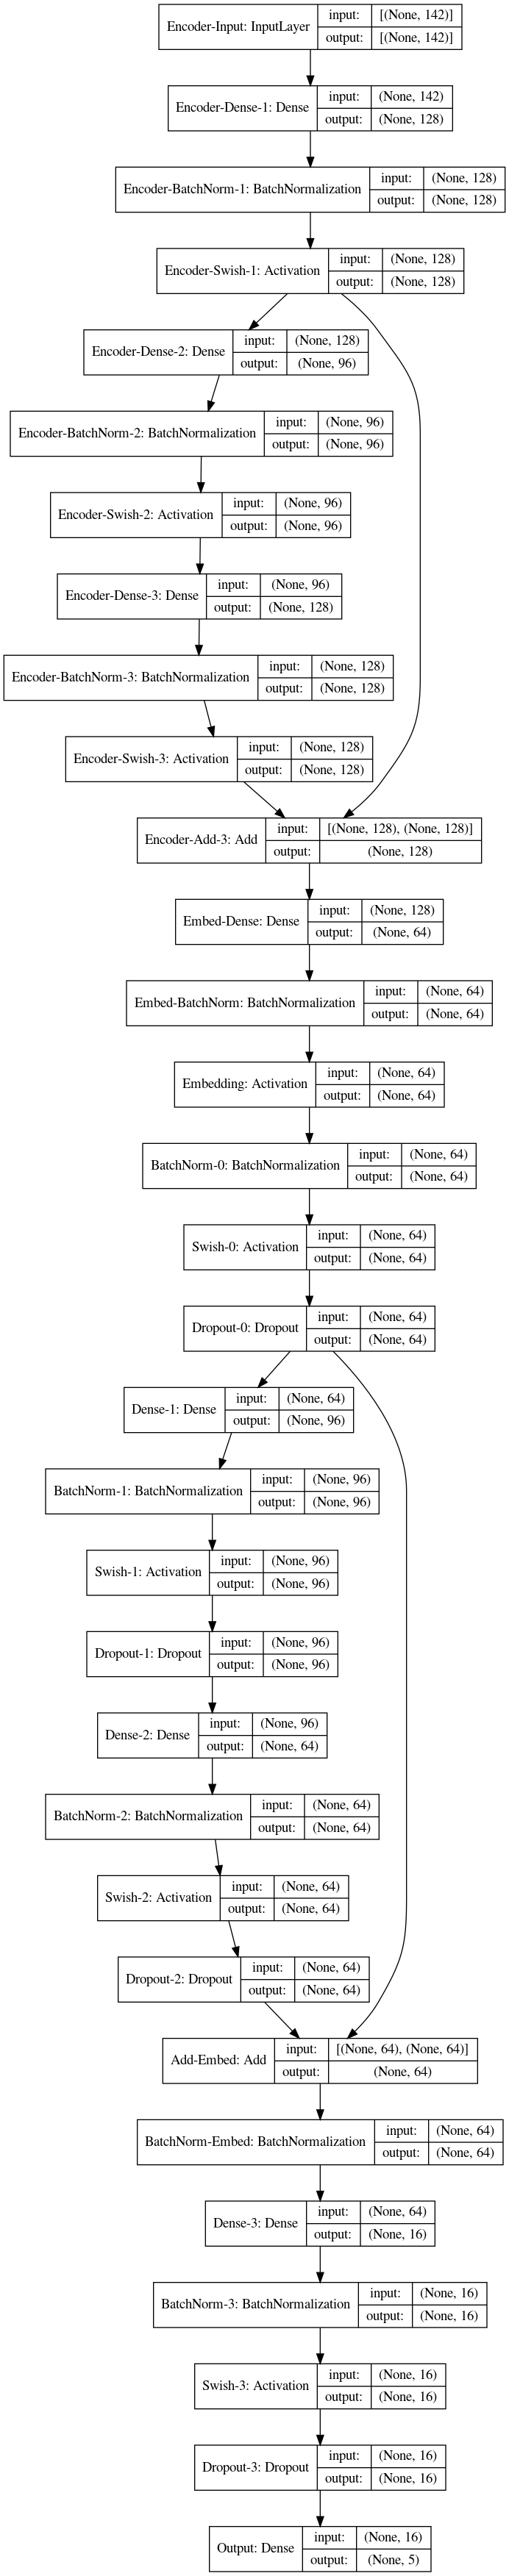

In [9]:
plot_model(
    model, to_file='./DNN_model.png', 
    show_shapes=True, show_layer_names=True
)

In [10]:
FOLD = 7
NUM_SEED = 3
VERBOSE = 0

np.random.seed(3)
seeds = np.random.randint(0, 100, size=NUM_SEED)

oof_score = 0
y_pred_meta_dnn = np.zeros((Ytrain.shape[0], 5))
y_pred_final_dnn = np.zeros((Xtest.shape[0], 5))
counter = 0
mini_batch_size = 128


for sidx, seed in enumerate(seeds):
    seed_score = 0
    
    kfold = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=seed)

    for idx, (train, val) in enumerate(kfold.split(Xtrain, Ytrain)):
        counter += 1
        print(">>>>>>>>>>  Fold - {}  <<<<<<<<<<\n".format(counter))

        train_x, train_y = Xtrain[train], Ytrain_oh[train]
        val_x, val_y = Xtrain[val], Ytrain_oh[val]

        model = Model(autoencoder.input, head(autoencoder.get_layer('Embedding').output),
                      name='DNN_model')
        
        model.compile(loss='categorical_crossentropy',
                      metrics=[F1Score(num_classes=5, average='macro')],
                      optimizer=Lookahead(AdamW(lr=1e-2, 
                                                weight_decay=1e-5, 
                                                clipvalue=700), 
                                          sync_period=10))

        early = EarlyStopping(monitor="val_loss", mode="min", 
                              restore_best_weights=True, 
                              patience=7, verbose=VERBOSE)

        reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, 
                                      min_lr=1e-5, patience=5, 
                                      verbose=VERBOSE, mode='min')

        chk_point = ModelCheckpoint('./DNN_model.h5', 
                                    monitor='val_loss', verbose=VERBOSE, 
                                    save_best_only=True, mode='min')
        
        history = model.fit(
            train_x, train_y, 
            batch_size=mini_batch_size,
            class_weight=class_weight, 
            epochs=150, 
            verbose=VERBOSE, 
            workers=5,
            callbacks=[reduce_lr, early, chk_point], 
            validation_data=(val_x, val_y)
        )
        
        model = load_model('./DNN_model.h5')

        y_pred = model.predict(val_x)
        y_pred_bin = np.array([np.argmax(y_pred, axis=1)]).T
        y_true_bin = np.array([np.argmax(val_y, axis=1)]).T
        y_pred_meta_dnn[val] += y_pred
        y_pred_final_dnn += model.predict(Xtest)
        
        score = 100 * f1_score(y_true_bin, y_pred_bin, average='macro')
        oof_score += score
        seed_score += score
        print("Seed-{} | Fold-{} | OOF Score: {}".format(seed, idx, score))
    
    print("\nSeed: {} | Aggregate OOF Score: {}\n\n".format(seed, (seed_score / FOLD)))


y_pred_meta_dnn = y_pred_meta_dnn / float(NUM_SEED)
y_pred_final_dnn = y_pred_final_dnn / float(counter)
oof_score /= float(counter)
print("Aggregate OOF Score: {}".format(oof_score))

>>>>>>>>>>  Fold - 1  <<<<<<<<<<

Seed-24 | Fold-0 | OOF Score: 72.70601439911948
>>>>>>>>>>  Fold - 2  <<<<<<<<<<

Seed-24 | Fold-1 | OOF Score: 72.22409510526613
>>>>>>>>>>  Fold - 3  <<<<<<<<<<

Seed-24 | Fold-2 | OOF Score: 72.87634182096951
>>>>>>>>>>  Fold - 4  <<<<<<<<<<

Seed-24 | Fold-3 | OOF Score: 74.05800608181302
>>>>>>>>>>  Fold - 5  <<<<<<<<<<

Seed-24 | Fold-4 | OOF Score: 73.956658988483
>>>>>>>>>>  Fold - 6  <<<<<<<<<<

Seed-24 | Fold-5 | OOF Score: 72.61675549529627
>>>>>>>>>>  Fold - 7  <<<<<<<<<<

Seed-24 | Fold-6 | OOF Score: 71.61633468348532

Seed: 24 | Aggregate OOF Score: 72.86488665349039


>>>>>>>>>>  Fold - 8  <<<<<<<<<<

Seed-3 | Fold-0 | OOF Score: 74.71492740971888
>>>>>>>>>>  Fold - 9  <<<<<<<<<<

Seed-3 | Fold-1 | OOF Score: 73.4135787690384
>>>>>>>>>>  Fold - 10  <<<<<<<<<<

Seed-3 | Fold-2 | OOF Score: 73.0248392449888
>>>>>>>>>>  Fold - 11  <<<<<<<<<<

Seed-3 | Fold-3 | OOF Score: 73.14115186779937
>>>>>>>>>>  Fold - 12  <<<<<<<<<<

Seed-3 | Fold-4 

In [11]:
np.savez_compressed('./DNN_Meta_Features.npz',
                    y_pred_meta_dnn=y_pred_meta_dnn, 
                    oof_score=oof_score,
                    y_pred_final_dnn=y_pred_final_dnn)

## Create submission file

In [12]:
test_df = pd.read_csv("../input/customer-churn-rate-prediction/dataset/test.csv")
submit_df = pd.DataFrame()
submit_df['customer_id'] = test_df['customer_id']
submit_df['churn_risk_score'] = np.array([np.argmax(y_pred_final_dnn, axis=1)]).T
submit_df['churn_risk_score'] = submit_df['churn_risk_score'].apply(lambda x: 5 if x==0 else x)
submit_df.head()

,customer_id,churn_risk_score
0,fffe43004900440031003700300030003400,3
1,fffe43004900440031003900370037003300,3
2,fffe43004900440034003800360037003000,3
3,fffe43004900440036003200370033003400,3
4,fffe43004900440035003000370031003900,5


In [13]:
submit_df.to_csv("./DNN_submission.csv", index=False)